# SVM Classification

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm
import numpy as np
import pandas as pd
import random

import seaborn as sns
plt.style.use('fivethirtyeight')


In [2]:
import statsmodels.api as sm
import statsmodels.formula.api as smf 
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

In [3]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import pickle

from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import r2_score #ordinary linear regression + w/ ridge regularization

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score

import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [4]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=18):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names, )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

In [5]:
def get_metrics(m):
    y_predict = m.predict(X_test_scaled)
    print("Model name:",m)
    print("Default threshold:")
    print("Score: {:6.4f}, Precision: {:6.4f}, Recall: {:6.4f}, F1: {:6.4f}".format(m.score(X_test_scaled, ytest),
                                                                                    precision_score(ytest, y_predict), 
                                                                                    recall_score(ytest, y_predict),
                                                                                    f1_score(ytest, y_predict)))

***

In [6]:
Xy = pd.read_pickle('data_for_regression_20k.pkl')

In [7]:
y_bi = Xy['country_USA_World_bi']
y_mlt = Xy['country_dest_id']   
X = Xy.drop(['country_dest_id','country_USA_World_bi'], axis = 1)

In [8]:
#Xy.describe()
nan_rows = X[X.isnull().any(1)]
len(nan_rows)/len(X)

0.0

In [9]:
y_bi.value_counts()/y_bi.value_counts().sum()

0.0    0.74553
1.0    0.25447
Name: country_USA_World_bi, dtype: float64

In [10]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y_bi, test_size=0.2, stratify=y_bi,random_state = 88)

In [11]:
print('X',len(X),'Xtrain', len(Xtrain), int((len(Xtrain)/len(X))*100), 
      'Xtest', len(Xtest), int((len(Xtest)/len(X))*100))

X 21366 Xtrain 17092 79 Xtest 4274 20


## 2. SVM

Steps:  
a. Scale Xtrain/Xtest  
b. Gridsearch CV best parameters (Number of neighbors) using  class balancing option  
c. Test other class balancing methods using optimal K  
d. Play with different probability thresholds for classification

### *a. Scale Xtrain and Xtest*

In [12]:
std_scale = StandardScaler()

X_train_scaled = std_scale.fit_transform(Xtrain)
X_test_scaled = std_scale.transform(Xtest)


### *b. Gridsearch CV best parameters*

In [ ]:
grid = {'C': [1, 10, 100, 1000], 'kernel': ['linear']}
svm = SVC(random_state=0, class_weight='balanced')
svm_cv=GridSearchCV(svm, grid, cv=3, scoring = 'recall')
svm_cv.fit(X_train_scaled, ytrain)

print("tuned hpyerparameters :(best parameters) ",svm_cv.best_params_)
print("best average recall score :",svm_cv.best_score_)

In [ ]:
# THE GRIDSEARCH RESULTS #
pkl_filename = 'models/svm_lin_gridsearch_cv_20k.pkl'
# Open
gridcv_pkl = open(pkl_filename, 'wb')
# Insert object
pickle.dump(svm_cv, gridcv_pkl)
# Close
gridcv_pkl.close()

In [32]:
get_metrics(svm_cv)

Model name: GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_neighbors': array([1, 2, 3, 4, 5, 6, 7, 8])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='recall', verbose=0)
Default threshold:
Score: 0.2877, Precision: 0.2912, Recall: 0.2877, F1: 0.2894


In [25]:
grid = {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf', 'poly']}
svm = SVC(random_state=0, class_weight='balanced')
svm_cv_rp=GridSearchCV(svm, grid, cv=3, scoring = 'f1')
svm_cv_rp.fit(X_train_scaled, ytrain)


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=0,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf', 'poly']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [26]:
print("tuned hpyerparameters :(best parameters) ",svm_cv_rp.best_params_)
print("best average recall score :",svm_cv_rp.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
best average recall score : 0.4122700202951906


In [27]:
# THE GRIDSEARCH RESULTS #
pkl_filename = 'models/svm_gridsearch_cv.pkl'
# Open
gridcv_pkl = open(pkl_filename, 'wb')
# Insert object
pickle.dump(svm_cv_rp, gridcv_pkl)
# Close
gridcv_pkl.close()

### *c. Define, fit, score model with best parameters*

In [28]:
model = SVC(random_state=0, class_weight='balanced', C = 10, gamma = 0.001, kernel = 'rbf')
svm_cv_best = model.fit(X_train_scaled, ytrain)
svm_cv_best.score(X_test_scaled, ytest)
get_metrics(svm_cv_best)

Model name: SVC(C=10, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=0, shrinking=True,
  tol=0.001, verbose=False)
Default threshold:
Score: 0.4995, Precision: 0.2953, Recall: 0.6967, F1: 0.4148


In [17]:
model = SVC(random_state=0, class_weight='balanced', C = 1, gamma = 0.0001, kernel = 'poly')
svm_cv_best = model.fit(X_train_scaled, ytrain)
svm_cv_best.score(X_test_scaled, ytest)
get_metrics(svm_cv_best)

Model name: SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='poly',
  max_iter=-1, probability=False, random_state=0, shrinking=True,
  tol=0.001, verbose=False)
Default threshold:
Score: 0.2550, Precision: 0.2547, Recall: 1.0000, F1: 0.4060


In [20]:
# THE MODEL WITH BEST PARAMS FIT ON SCALED TRAIN DATA #
pkl_filename_2 = 'models/svm_cv_best.pkl'
# Open 
model_pkl = open(pkl_filename_2, 'wb')
# Insert object
pickle.dump(svm_cv_best, model_pkl)
# Close
model_pkl.close()

***

In [35]:
model = KNeighborsClassifier(n_neighbors = 1)
knn_cv_best = model.fit(X_train_scaled, ytrain)
knn_cv_best.score(X_test_scaled, ytest)
get_metrics(knn_cv_best)

Model name: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=1, p=2,
           weights='uniform')
Default threshold:
Score: 0.6085, Precision: 0.2912, Recall: 0.2877, F1: 0.2894


*How this performs on the training data*

In [40]:
knn_cv_best.score(X_train_scaled, ytrain)

0.9941512245873521

In [41]:
y_pred_train = knn_cv_best.predict(X_train_scaled)
recall_score(ytrain, y_pred_train)

0.9896007710647796

*Hos this performs on the test data*

In [37]:
y_predict = knn_cv_best.predict(X_test_scaled)

In [38]:
knn_cv_best.score(X_test_scaled, ytest)

0.6084804858846025

In [39]:
recall_score(ytest, y_predict)

0.28768512882937713

### ^Best KNN model is 60% accurate but only picks up <30% of potential EU travellers^

In [45]:
"""
probs=np.arange(0.,1.1,0.1)
for p in probs:
    #knn_pp = knn_cv_best.fit(X_adasyn, y_adasyn)
    y_pred_knn = knn_cv_best.predict_proba(X_test_scaled)[:,1] > p
    print(p,recall_score(ytest, y_pred_knn))
"""

'\nprobs=np.arange(0.,1.1,0.1)\nfor p in probs:\n    #knn_pp = knn_cv_best.fit(X_adasyn, y_adasyn)\n    y_pred_knn = knn_cv_best.predict_proba(X_test_scaled)[:,1] > p\n    print(p,recall_score(ytest, y_pred_knn))\n'

In [43]:
from sklearn.metrics import roc_auc_score, roc_curve

fpr, tpr, thresholds = roc_curve(ytest, knn_cv_best.predict_proba(X_test_scaled)[:,1])

ROC AUC score =  0.5095937509081142


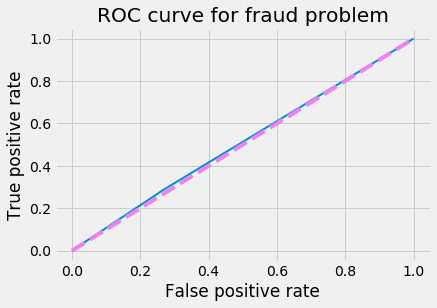

In [44]:
plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for fraud problem');
print("ROC AUC score = ", roc_auc_score(ytest, knn_cv_best.predict_proba(X_test_scaled)[:,1]))

***

In [36]:
# THE MODEL WITH BEST PARAMS FIT ON SCALED TRAIN DATA #
pkl_filename_2 = 'models/knn_cv_model.pkl'
# Open 
model_pkl = open(pkl_filename_2, 'wb')
# Insert object
pickle.dump(knn_cv_best, model_pkl)
# Close
model_pkl.close()

### *d. Save to pickle*

In [160]:

# Dump the trained decision tree classifier with Pickle
logreg_cv_pkl_filename = 'models/logreg_cv.pkl'
# Open the file to save as pkl file
logreg_cv_model_pkl = open(logreg_cv_pkl_filename, 'wb')

#pickle.dump(logreg_cv, logreg_cv_model_pkl)
# OR???
pickle.dump(logreg_cv_best, logreg_cv_model_pkl)

# Close the pickle instances
logreg_cv_model_pkl.close()

### *e. Explore important features*

**Import best classifier pickle**

In [109]:
logreg_cv = pd.read_pickle('models/logreg_cv.pkl')

In [125]:
coef_dict = {}
for coef, feat in zip(logreg_cv_best.coef_[0],Xtrain.columns):
    coef_dict[feat] = coef
sorted(coef_dict.items(), key=lambda kv: kv[1], reverse=True)

[('signup_app_2_moweb', 0.019718034564082648),
 ('month_first_booking', 0.006910153113009323),
 ('month_active', 7.427366192803331e-05),
 ('age', 0.0),
 ('signup_flow', 0.0),
 ('gender_female', 0.0),
 ('gender_male', 0.0),
 ('gender_other', 0.0),
 ('signup_method_basic', 0.0),
 ('signup_method_facebook', 0.0),
 ('language_ca', 0.0),
 ('language_cs', 0.0),
 ('language_da', 0.0),
 ('language_de', 0.0),
 ('language_el', 0.0),
 ('language_en', 0.0),
 ('language_es', 0.0),
 ('language_fi', 0.0),
 ('language_fr', 0.0),
 ('language_hr', 0.0),
 ('language_hu', 0.0),
 ('language_id', 0.0),
 ('language_is', 0.0),
 ('language_it', 0.0),
 ('language_ja', 0.0),
 ('language_ko', 0.0),
 ('language_nl', 0.0),
 ('language_no', 0.0),
 ('language_pl', 0.0),
 ('language_pt', 0.0),
 ('language_ru', 0.0),
 ('language_sv', 0.0),
 ('language_th', 0.0),
 ('language_tr', 0.0),
 ('year_created', 0.0),
 ('month_created', 0.0),
 ('day_created', 0.0),
 ('year_active', 0.0),
 ('day_active', 0.0),
 ('year_first_booki

In [126]:
print(len(logreg_cv.best_estimator_.coef_),len(Xtrain.columns))

1 66


In [111]:
logreg_cv.best_estimator_.coef_[0][0]

0.0

In [112]:
#coef_dict = {}
#for coef, feat in zip(logreg_cv.best_estimator_.coef_[0],Xtrain.columns):
#    coef_dict[feat] = coef
#sorted(coef_dict.items(), key=lambda kv: kv[1], reverse=True)

In [122]:
features = pd.DataFrame([coef_dict]).transpose().reset_index()
features.columns = ['feature','weight']
features['abs_weight'] = abs(features.weight)
features = features.sort_values(by='abs_weight', ascending = False).reset_index(drop=True)
#features

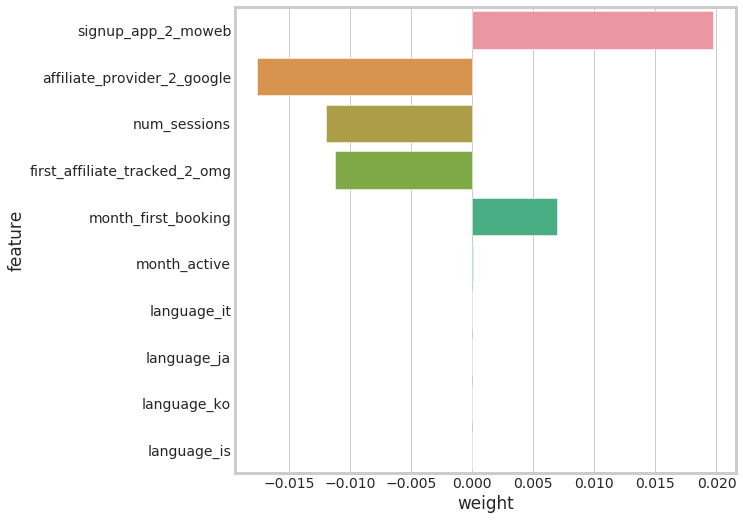

In [127]:
sns.set_style("whitegrid")
ftplot, ax = plt.subplots(figsize = (8,8))
ftplot = sns.barplot(y="feature", x="weight", 
            orient="h", data=features[0:10])
y_lab = ['Number of sessions', 'Affiliate provider = Google', 'Affiliate channel = Direct', 
         'Number of actions', 'First device = iPad', 'Signup App = Moweb', 
         'First browser = IE', 'First device = Mac desktop']
#ax.set_yticklabels(labels=y_lab, ha='right');

axes = ftplot.axes
#axes.set_xlim(-.1,.1);

**Oversampling**

In [130]:
model_2 = LogisticRegression(C = 0.001, penalty = 'l1', random_state=0)



In [132]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_sample(X_train_scaled,ytrain)
logit_over_sampled = model_2.fit(X_resampled, y_resampled)
logit_over_sampled.score(X_test_scaled, ytest)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.5537059948262287

In [152]:
y_predict = logit_over_sampled.predict(X_test_scaled)
print("Default threshold:")
print("Precision: {:6.4f},   Recall: {:6.4f}, F1: {:6.4f}".format(precision_score(ytest, y_predict), 
                                                                  recall_score(ytest, y_predict),
                                                                  f1_score(ytest, y_predict)))

Default threshold:
Precision: 0.7547,   Recall: 0.5270, F1: 0.6206


In [119]:
from collections import Counter
Counter(y_resampled)

Counter({1.0: 51413, 0.0: 51413})

**SMOTE**

In [137]:
from imblearn.over_sampling import SMOTE
X_smoted, y_smoted = SMOTE(random_state=42).fit_sample(X_train_scaled,ytrain)
logit_smote = model_2.fit(X_smoted, y_smoted)
logit_smote.score(X_test_scaled, ytest)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.5263749859408391

In [154]:
y_predict = logit_smote.predict(X_test_scaled)
print("Default threshold:")
print("Precision: {:6.4f},   Recall: {:6.4f}, F1: {:6.4f}".format(precision_score(ytest, y_predict), 
                                                                  recall_score(ytest, y_predict),
                                                                  f1_score(ytest, y_predict)))

Default threshold:
Precision: 0.7553,   Recall: 0.5172, F1: 0.6140


In [128]:
#cm = print_confusion_matrix(confusion_matrix(ytest, model.predict(X_test_scaled)), ['Class 0', 'Class 1'])


**ADASYN**

In [133]:
from imblearn.over_sampling import ADASYN
X_adasyn, y_adasyn = ADASYN(random_state=42).fit_sample(X_train_scaled,ytrain)
logit_adasyn = model_2.fit(X_adasyn, y_adasyn)
logit_adasyn.score(X_test_scaled, ytest)


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.5552243842087504

In [134]:
get_metrics(logit_adasyn)

Model name: LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=0, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
Default threshold:
Score: 0.5552, Precision: 0.7401, Recall: 0.5928, F1: 0.6583


In [ ]:
y_predict = logit_adasyn.predict(X_test_scaled)
print("Default threshold:")
print("Precision: {:6.4f},   Recall: {:6.4f}, F1: {:6.4f}".format(precision_score(ytest, y_predict), 
                                                                  recall_score(ytest, y_predict),
                                                                  f1_score(ytest, y_predict)))

**Undersampling**

In [135]:
from imblearn.under_sampling import RandomUnderSampler
X_under, y_under = RandomUnderSampler(random_state=42).fit_sample(X_train_scaled,ytrain)

logit_undersample = model_2.fit(X_under, y_under)
model.score(X_test_scaled, ytest)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.5537059948262287

In [138]:
models = [logit_undersample, logit_adasyn, logit_smote, logit_over_sampled]
for m in models:
    get_metrics(m)


Model name: LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=0, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
Default threshold:
Score: 0.5264, Precision: 0.7496, Recall: 0.5177, F1: 0.6124
Model name: LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=0, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
Default threshold:
Score: 0.5264, Precision: 0.7496, Recall: 0.5177, F1: 0.6124
Model name: LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=0, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
Default thresho

Regular cv: Score: 0.6008, Precision: 0.7400, Recall: 0.6903, F1: 0.7143

**My metric: Recall of class 0**
Precision: Be more sure someone is going to US Before you market
Recall: Catching people going to US

from sklearn.metrics import classification_report
for m in models:
    print()

Next steps: Lower threshold for how you classify Europeans (change to 1)
1. ypredict = m.predict_proba(X_test)[:,1] > 0.6  
2. Run KNN and compare AUCs
3. Random forest + feature importance
4. Plot AUCs for all models

***

## 2. KNN

# II. Refined Models

### 1. Decision Tree

In [174]:
model = DecisionTreeClassifier(max_depth=2)
model.fit(Xtrain, ytrain)
model.score(Xtest, ytest)

0.6256588039633646

In [34]:
skf = StratifiedKFold(n_splits=2)
skf.get_n_splits(X, y)

2

In [48]:
skf.split(X, y)

<generator object _BaseKFold.split at 0x1a15e1f990>

In [54]:
#xtrain